# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow opencv-python matplotlib

In [3]:
!pip list

Package                           Version
--------------------------------- ------------------
absl-py                           2.1.0
aiobotocore                       2.12.3
aiohttp                           3.9.5
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.16
altair                            5.0.1
anaconda-anon-usage               0.4.4
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.5.1
anaconda-navigator                2.6.0
anaconda-project                  0.11.1
annotated-types                   0.6.0
anyio                             4.2.0
appdirs                           1.4.4
archspec                          0.2.3
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.2.3
asgiref                           3.8.1
astroid                           2.14.2
astropy           

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [4]:
import cv2
import imghdr



C:\Users\Aksan Pramod\AppData\Local\Temp\ipykernel_8996\2893020116.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
data_dir = r'D:\GymBuddy\CNN\Data'

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
os.listdir(data_dir)

['Barbell',
 'Bench Press',
 'Calf Machine',
 'Dumbbell',
 'Pec deck',
 'Smith machine']

In [8]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(256, 256),
    batch_size=32,  # Set batch size
    label_mode='categorical'  # Ensure labels are one-hot encoded
)

class_names = data.class_names
print("Class names:", class_names)

Found 2027 files belonging to 6 classes.
Class names: ['Barbell', 'Bench Press', 'Calf Machine', 'Dumbbell', 'Pec deck', 'Smith machine']


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

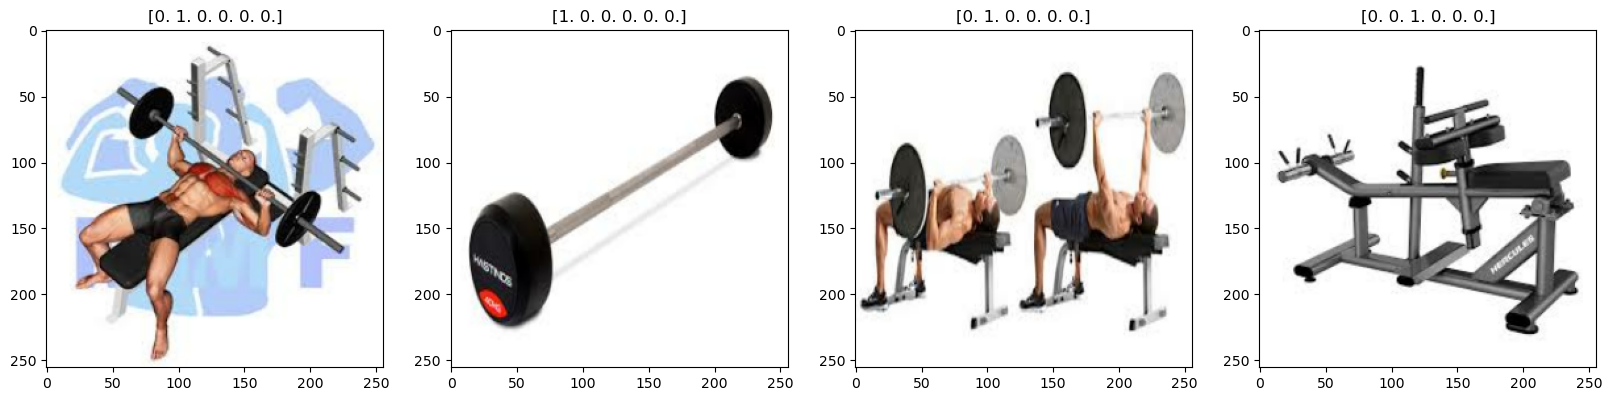

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [14]:
data = data.map(lambda x,y: (x/255.0, y))

In [15]:
data.as_numpy_iterator().next()

(array([[[[0.827451  , 0.827451  , 0.827451  ],
          [0.827451  , 0.827451  , 0.827451  ],
          [0.827451  , 0.827451  , 0.827451  ],
          ...,
          [0.83137256, 0.83137256, 0.83137256],
          [0.83137256, 0.83137256, 0.83137256],
          [0.83137256, 0.83137256, 0.83137256]],
 
         [[0.827451  , 0.827451  , 0.827451  ],
          [0.827451  , 0.827451  , 0.827451  ],
          [0.827451  , 0.827451  , 0.827451  ],
          ...,
          [0.83137256, 0.83137256, 0.83137256],
          [0.83137256, 0.83137256, 0.83137256],
          [0.83137256, 0.83137256, 0.83137256]],
 
         [[0.8278722 , 0.8278722 , 0.8278722 ],
          [0.8278722 , 0.8278722 , 0.8278722 ],
          [0.8278722 , 0.8278722 , 0.8278722 ],
          ...,
          [0.8317938 , 0.8317938 , 0.8317938 ],
          [0.8317938 , 0.8317938 , 0.8317938 ],
          [0.8317938 , 0.8317938 , 0.8317938 ]],
 
         ...,
 
         [[0.8352941 , 0.8352941 , 0.8352941 ],
          [0.83529

# 5. Split Data

In [16]:
def split_dataset(dataset, train_size=0.7, val_size=0.2):
    dataset_size = len(dataset)
    train_size = int(dataset_size * train_size)
    val_size = int(dataset_size * val_size)
    test_size = dataset_size - train_size - val_size

    # Shuffle and split dataset
    dataset = dataset.shuffle(buffer_size=dataset_size)
    train = dataset.take(train_size)
    val = dataset.skip(train_size).take(val_size)
    test = dataset.skip(train_size + val_size).take(test_size)
    return train, val, test

train, val, test = split_dataset(data)

# 6. Build Deep Learning Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

model = Sequential([
    Input(shape=(256, 256, 3)),  # Input layer specifying the input shape
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(6, activation='softmax')  # Number of classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# TensorBoard callback
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Train model
hist = model.fit(
    train,
    epochs=20,
    validation_data=val,
    callbacks=[tensorboard_callback]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,697,910 (14.11 MB)

 Trainable params: 3,697,910 (14.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 49s 635ms/step - accuracy: 0.2164 - loss: 1.8300 - val_accuracy: 0.4922 - val_loss: 1.3572
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 540ms/step - accuracy: 0.5079 - loss: 1.3471 - val_accuracy: 0.6536 - val_loss: 1.0084
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 683ms/step - accuracy: 0.6574 - loss: 0.9459 - val_accuracy: 0.8516 - val_loss: 0.5675
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 612ms/step - accuracy: 0.8472 - loss: 0.5124 - val_accuracy: 0.9245 - val_loss: 0.2936
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 545ms/step - accuracy: 0.9291 - loss: 0.2795 - val_accuracy: 0.9583 - val_loss: 0.1807
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 479ms/step - accuracy: 0.9550 - loss: 0.1651 - val_accuracy: 0.9635 - val_loss: 0.1422
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 494ms/step - accuracy: 0.9784 - loss: 0.0964 - val_accuracy: 0.9844 - val_loss: 0.0683
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 523ms/step - accuracy: 0.9905 - loss: 0.0508 - val_accu

# 8. Plot Performance

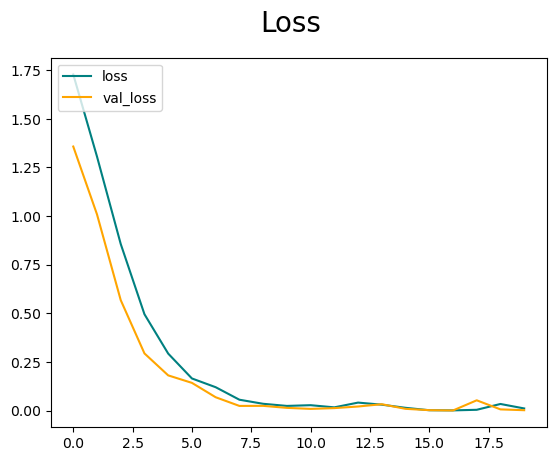

In [18]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

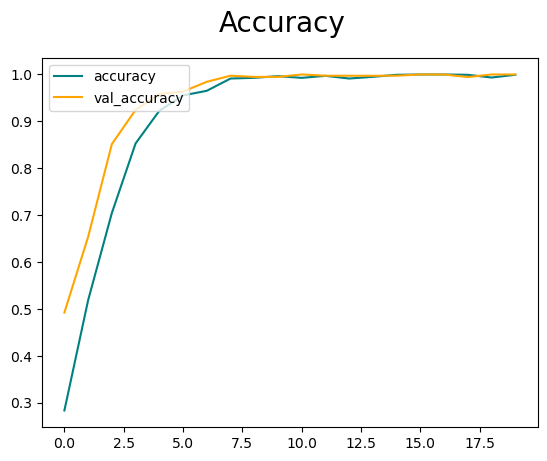

In [19]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [20]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [21]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [22]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


In [23]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [24]:
import cv2

In [30]:
import numpy as np
from keras.preprocessing import image
# Assuming you've loaded the class names earlier
img_path = 'old_dumbells.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(256, 256))

# Preprocess the image (convert to array and normalize)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image

# Make prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])  # Get the index of the highest probability

# Print the predicted class using stored class names
print(f"Predicted Class: {class_names[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Class: Bench Press


In [32]:
import numpy as np
from keras.preprocessing import image
# Assuming you've loaded the class names earlier
img_path = "seated-calf-raise-machine-1000x1000.jpg"  # Replace with your image path
img = image.load_img(img_path, target_size=(256, 256))

# Preprocess the image (convert to array and normalize)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image

# Make prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])  # Get the index of the highest probability

# Print the predicted class using stored class names
print(f"Predicted Class: {class_names[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Class: Calf Machine


# 11. Save the Model

In [33]:

model.save('gymapp.h5') 


In [34]:
# Save the model in the native Keras format
model.save('my_model.keras')
